# 决策树泰坦尼克实战

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 读取数据
titanic_data = pd.read_csv('data/titanic.txt')

# 选择特征
features = ['pclass', 'age', 'sex']
X = titanic_data[features]
y = titanic_data['survived']

# 处理缺失值
X.loc[:, 'age'] = X.loc[:, 'age'].fillna(X.loc[:, 'age'].mean())

# 处理分类变量
X.loc[:, 'sex'] = X.loc[:, 'sex'].map({'female': 0, 'male': 1})
X.loc[:, 'pclass'] = X.loc[:, 'pclass'].map({'1st': 1, '2nd': 2, '3rd': 3})

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
from sklearn.tree import DecisionTreeClassifier

# 创建决策树分类器
dt_classifier = DecisionTreeClassifier(random_state=42)

# 训练模型
dt_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = dt_classifier.predict(X_test)

# 计算准确率
accuracy = dt_classifier.score(X_test, y_test)
print(f"决策树模型的准确率: {accuracy:.4f}")


决策树模型的准确率: 0.8096


In [22]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林分类器，调整超参数以提高准确率
rf_classifier = RandomForestClassifier(
    n_estimators=1000,          # 增加树的数量
    max_depth=6,               # 限制树的深度防止过拟合
    random_state=42
)

# 训练模型
rf_classifier.fit(X_train, y_train)

# 在测试集上进行预测
rf_pred = rf_classifier.predict(X_test)

# 计算准确率
rf_accuracy = rf_classifier.score(X_test, y_test)
print(f"随机森林模型的准确率: {rf_accuracy:.4f}")

# 对比两个模型的准确率
print(f"\n模型对比:")
print(f"决策树准确率: {accuracy:.4f}")
print(f"随机森林准确率: {rf_accuracy:.4f}")


随机森林模型的准确率: 0.8249

模型对比:
决策树准确率: 0.8096
随机森林准确率: 0.8249


In [19]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],#n_estimators是随机森林中决策树的数量
    'max_depth': [6, 8, 10,15],#max_depth是决策树的最大深度
}

# 创建随机森林分类器
rf = RandomForestClassifier(random_state=42)

# 创建网格搜索对象
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("\n最佳参数组合:")
print(grid_search.best_params_)

# 使用最佳参数的模型进行预测
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_accuracy = best_rf.score(X_test, y_test)

print(f"\n使用网格搜索优化后的随机森林准确率: {best_rf_accuracy:.4f}")

# 对比所有模型的准确率
print(f"\n模型性能对比:")
print(f"基础决策树准确率: {accuracy:.4f}")
print(f"基础随机森林准确率: {rf_accuracy:.4f}")
print(f"网格搜索优化的随机森林准确率: {best_rf_accuracy:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

最佳参数组合:
{'max_depth': 6, 'n_estimators': 200}

使用网格搜索优化后的随机森林准确率: 0.8249

模型性能对比:
基础决策树准确率: 0.8096
基础随机森林准确率: 0.7614
网格搜索优化的随机森林准确率: 0.8249


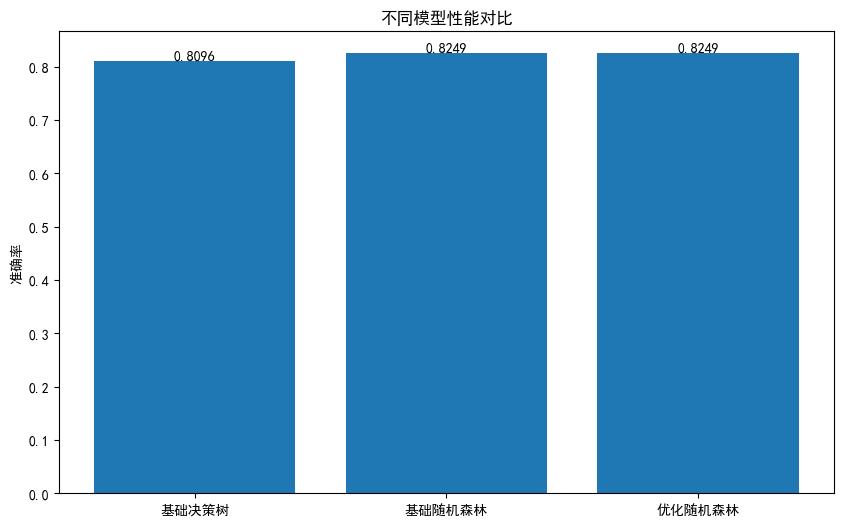

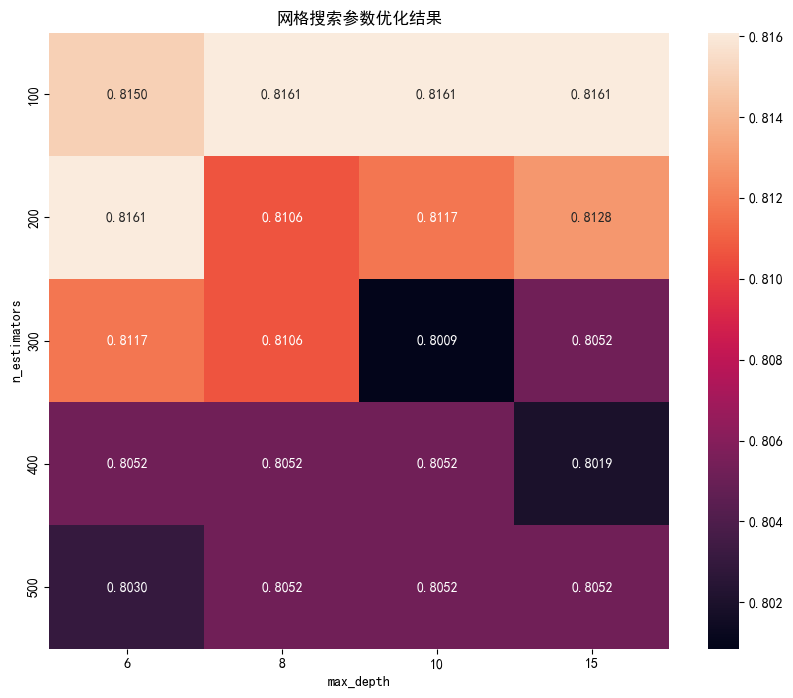

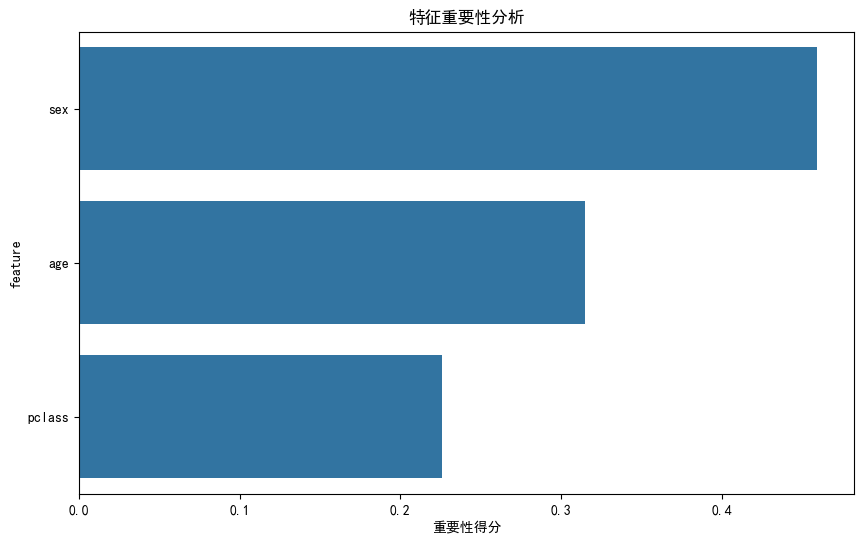

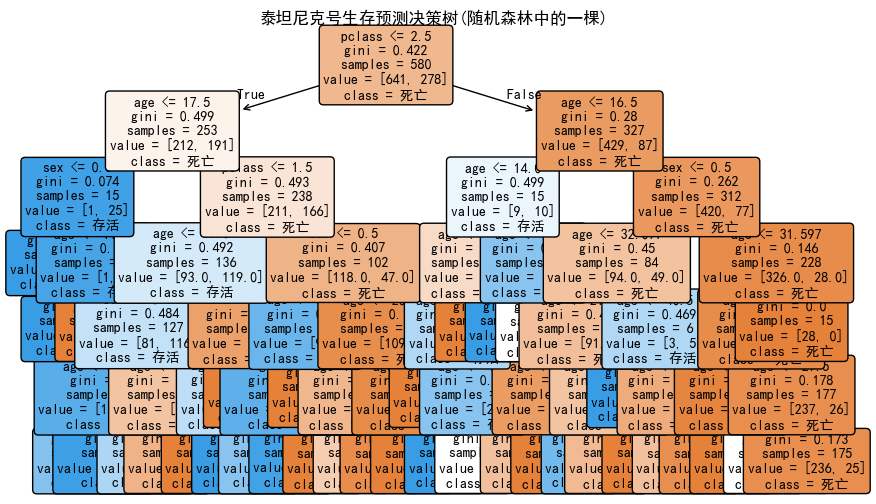

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 创建性能对比柱状图
model_names = ['基础决策树', '基础随机森林', '优化随机森林']
accuracies = [accuracy, rf_accuracy, best_rf_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.title('不同模型性能对比')
plt.ylabel('准确率')

# 为柱状图添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

# 绘制网格搜索结果热力图
results = grid_search.cv_results_
scores = np.array(results['mean_test_score'])
scores = scores.reshape(len(param_grid['n_estimators']), 
                       len(param_grid['max_depth']))

plt.figure(figsize=(10, 8))
sns.heatmap(scores, annot=True, fmt='.4f', 
            xticklabels=param_grid['max_depth'],
            yticklabels=param_grid['n_estimators'])
plt.title('网格搜索参数优化结果')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

# 分析特征重要性
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('特征重要性分析')
plt.xlabel('重要性得分')
plt.show()
from sklearn import tree

# 可视化决策树路径
plt.figure(figsize=(10, 6))
# 获取随机森林中的第一棵决策树进行可视化
first_tree = best_rf.estimators_[0]
tree.plot_tree(first_tree, feature_names=features, class_names=['死亡', '存活'], 
               filled=True, rounded=True, fontsize=10)
plt.title('泰坦尼克号生存预测决策树(随机森林中的一棵)')
plt.show()
